In [39]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import FloatType, StructType, StringType, StructField, IntegerType
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np

In [40]:
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

combined_schema = StructType([
    StructField('STATION', StringType()),
    StructField('NAME', StringType()),
    StructField('LATITUDE', FloatType()),
    StructField('LONGITUDE', FloatType()),
    StructField('ELEVATION', FloatType()),
    StructField('AWND', FloatType()),
    StructField('PRCP', FloatType()),
    StructField('SNOW', FloatType()),
    StructField('SNWD', FloatType()),
    StructField('TAVG', FloatType()),
    StructField('CRASHCOUNT', IntegerType()),
    StructField('YEAR', IntegerType()),
    StructField('MONTH', IntegerType()),
    StructField('DAY', IntegerType())
])


In [41]:
combinedDF = spark.read.options(header = 'True').schema(combined_schema).csv('combined.csv')
combinedDF = combinedDF.drop('STATION', 'NAME', 'ELEVATION', 'LATITUDE', 'LONGITUDE') 
# elevation, latitude and longitude have a large number of missing values
combinedDF.show(30)

+-----+----+----+----+----+----------+-----+---+
| AWND|PRCP|SNOW|SNWD|TAVG|CRASHCOUNT|MONTH|DAY|
+-----+----+----+----+----+----------+-----+---+
|10.74| 0.0| 0.0| 0.0|50.0|        49|    4|  1|
| 8.28| 0.0| 0.0| 0.0|40.0|        35|    4|  2|
|10.51| 0.0| 0.0| 0.0|40.0|        49|    4|  3|
| 4.25|0.04| 0.0| 0.0|37.0|        38|    4|  4|
| 8.05|0.11| 0.0| 0.0|48.0|        60|    4|  5|
| 5.59| 0.0| 0.0| 0.0|47.0|        49|    4|  6|
| 5.82| 0.0| 0.0| 0.0|50.0|        52|    4|  7|
| 4.92| 0.0| 0.0| 0.0|64.0|        64|    4|  8|
| 6.71| 0.0| 0.0| 0.0|73.0|        59|    4|  9|
| 7.61| 0.0| 0.0| 0.0|76.0|        70|    4| 10|
| 9.62| 0.0| 0.0| 0.0|72.0|        55|    4| 11|
|10.29|0.67| 0.0| 0.0|55.0|        49|    4| 12|
| 5.14| 0.0| 0.0| 0.0|54.0|        53|    4| 13|
| 5.59| 0.0| 0.0| 0.0|54.0|        58|    4| 14|
| 8.28| 0.0| 0.0| 0.0|56.0|        52|    4| 15|
| 6.04| 0.0| 0.0| 0.0|60.0|        46|    4| 16|
| 5.82| 0.0| 0.0| 0.0|65.0|        62|    4| 17|
| 9.17|0.04| 0.0| 0.

In [42]:
features = combinedDF.columns

features.pop(5)

vectorAssembler = VectorAssembler(inputCols = features, outputCol = 'features')

vDF = vectorAssembler.transform(combinedDF)
vDF = vDF.select(['features', 'CRASHCOUNT'])

split = vDF.randomSplit([.8, .2], seed = 12345)

trainingData = split[0]
testData = split[1]

lr = LinearRegression(featuresCol = 'features', labelCol = 'CRASHCOUNT', maxIter = 10, regParam = .3, elasticNetParam = .8)

lrModel = lr.fit(trainingData)

In [43]:
#print('Coefficients:', str(lrModel.coefficients))

count = 0

print('Coefficients per feature:')
for item in lrModel.coefficients:
    print(features[count] + ':', item)
    count += 1
print()

    
trainingSummary = lrModel.summary
print('RMSE:', trainingSummary.rootMeanSquaredError)
print('R squared:', trainingSummary.r2)

Coefficients per feature:
AWND: 0.6590887741121741
PRCP: 0.0
SNOW: -1.3372764638638435
SNWD: -0.7240295709285356
TAVG: 0.17799762976077024
MONTH: 0.04447601690300508
DAY: -0.05181953403363659

RMSE: 15.65479033763715
R squared: 0.06788566821269193


In [44]:
lr_predictions = lrModel.transform(testData)
lr_predictions.select('prediction', 'CRASHCOUNT', 'features').show(5, False)

from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol = 'prediction', labelCol = 'CRASHCOUNT', metricName = 'r2')
print('R squared on test data:', lr_evaluator.evaluate(lr_predictions))
testResult = lrModel.evaluate(testData)
print('RMSE on test data:', testResult.rootMeanSquaredError)

+-----------------+----------+----------------------------------------------------------------+
|prediction       |CRASHCOUNT|features                                                        |
+-----------------+----------+----------------------------------------------------------------+
|60.86242379345681|55        |[0.8899999856948853,0.029999999329447746,0.0,0.0,49.0,10.0,14.0]|
|65.64618057917546|59        |[1.340000033378601,0.7599999904632568,0.0,0.0,75.0,8.0,15.0]    |
|57.05293320973557|67        |[1.5700000524520874,0.0,0.0,0.0,25.0,1.0,6.0]                   |
|58.9684650252729 |57        |[1.5700000524520874,0.0,0.0,0.0,40.0,12.0,30.0]                 |
|59.86519465279066|39        |[1.5700000524520874,0.07999999821186066,0.0,0.0,43.0,12.0,23.0] |
+-----------------+----------+----------------------------------------------------------------+
only showing top 5 rows

R squared on test data: 0.07517689841308306
RMSE on test data: 16.643762849196168


## Slightly worse

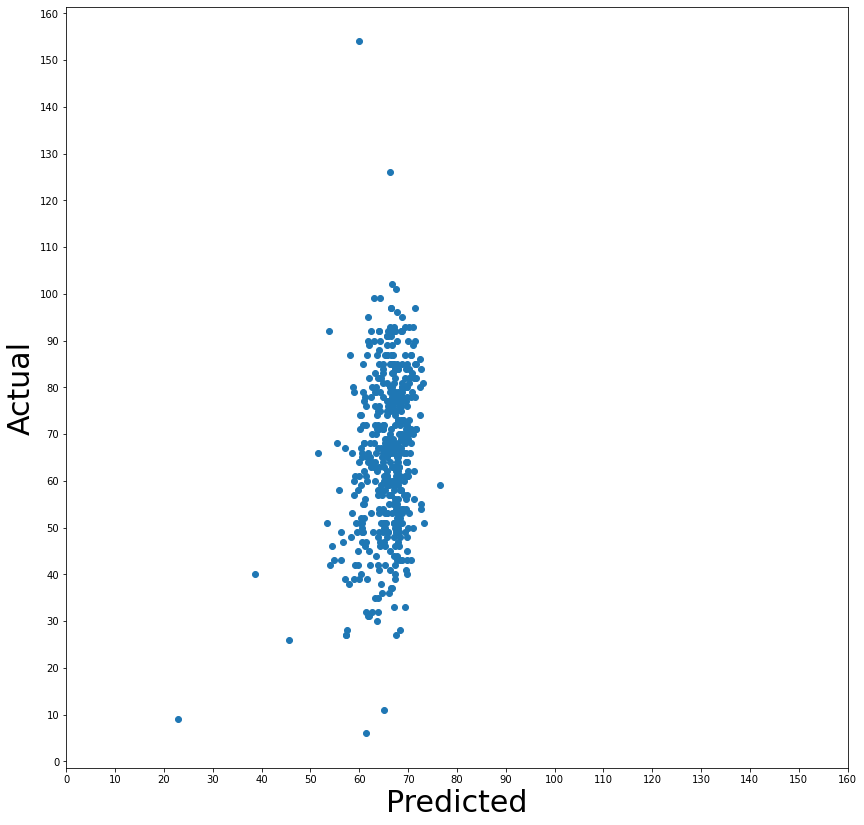

In [45]:
pdDF = lr_predictions.toPandas()
fig, ax = plt.subplots()
fig.set_size_inches(14,14)
plt.scatter(pdDF.prediction, pdDF.CRASHCOUNT)
ax.xaxis.set_ticks(np.arange(0, 170, 10))
ax.yaxis.set_ticks(np.arange(0, 170, 10))
plt.ylabel('Actual')
plt.xlabel('Predicted')
ax.xaxis.label.set_size(30)
ax.yaxis.label.set_size(30)

In [46]:
trainingData.describe().show()

+-------+-----------------+
|summary|       CRASHCOUNT|
+-------+-----------------+
|  count|             1975|
|   mean|65.54886075949366|
| stddev|16.21894640101575|
|    min|                4|
|    max|              109|
+-------+-----------------+



In [47]:
from pyspark.ml.regression import DecisionTreeRegressor

dt = DecisionTreeRegressor(featuresCol ='features', labelCol = 'CRASHCOUNT')
dtModel = dt.fit(trainingData)
dtPredictions = dtModel.transform(testData)
dtEvaluator = RegressionEvaluator(
    labelCol = "CRASHCOUNT", predictionCol = "prediction", metricName = "rmse")
rmse = dtEvaluator.evaluate(dtPredictions)
print("Root Mean Squared Error (RMSE) on test data: ", rmse)

Root Mean Squared Error (RMSE) on test data:  16.805152604072795


In [48]:
dtModel.featureImportances

SparseVector(7, {0: 0.1706, 1: 0.0803, 2: 0.0329, 3: 0.052, 4: 0.3466, 5: 0.198, 6: 0.1196})

In [49]:
features

['AWND', 'PRCP', 'SNOW', 'SNWD', 'TAVG', 'MONTH', 'DAY']

(array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

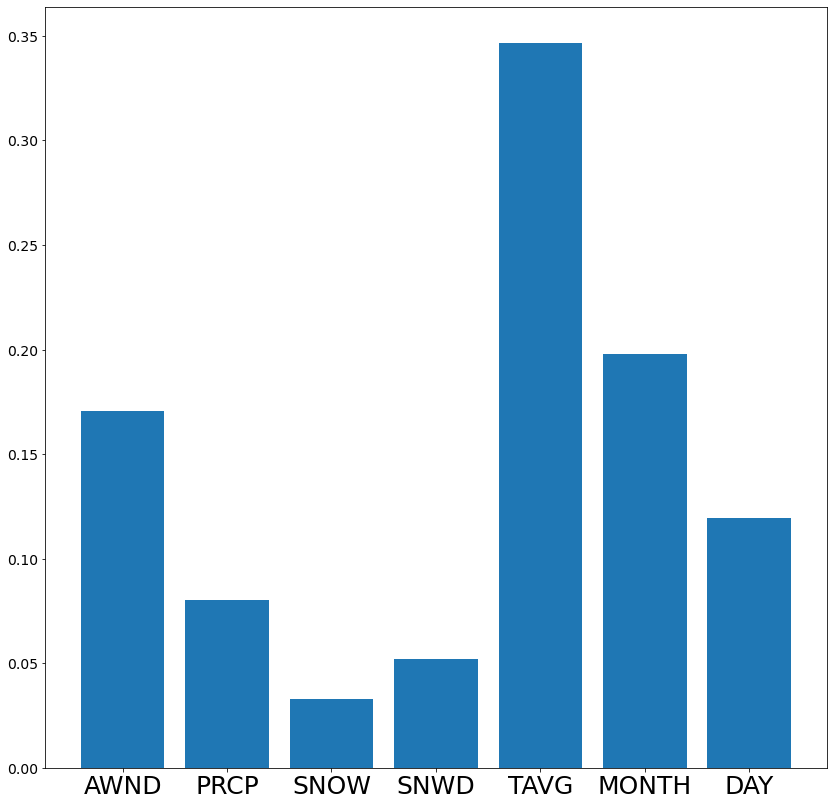

In [50]:
fig, ax = plt.subplots()
fig.set_size_inches(14,14)
plt.bar(features, dtModel.featureImportances)
plt.xticks(fontsize=25)
plt.yticks(fontsize=14)

# It seems that year is by far the best predictor